# qPCR vs RNA-seq

For the vehicle condition, we can compare RNA-seq and qPCR quantifications as a sanity check.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Load qPCR quantification of candidate biomarker genes, relative to GAPDH

In [2]:
df = pd.read_csv("../data/qpcr_veh_proliferation.csv", sep='\t')

In [3]:
df['cell line'] = df['cell line'].str.upper()

In [4]:
genes = ['MYOD1', 'MYOG', 'MYCN', 'GAPDH'] # 'P3F', 


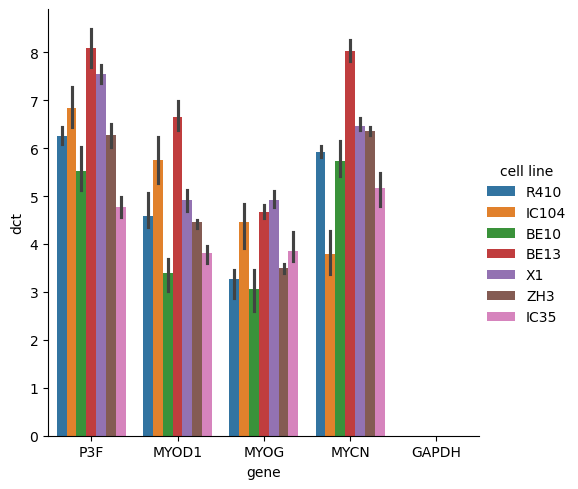

In [5]:
sns.catplot(data=df, x='gene', y='dct', hue='cell line', kind='bar', estimator='mean', errorbar=('ci', 100))

## Load RNA-seq gene expression

In [6]:
tpm = pd.read_csv("../data/RMS_TPMs.csv.gz", sep='\t').set_index('gene')

In [7]:
expr = tpm.loc[genes].copy()

In [8]:
expr.columns = [c.upper() for c in expr.columns]
expr = expr.reset_index()
lexpr = np.log2(expr.set_index('gene').drop(columns=['GENE_ID']) + 1)


In [9]:
# log2(GAPDH) - log2(gene)
dl2 = - lexpr.sub(lexpr.iloc[-1], axis=1)
dl2 = dl2.melt(ignore_index=False, var_name='sample_rep', value_name='log2FC_GAPDH')
dl2['cell'] = dl2['sample_rep'].apply(lambda x : x.split('.')[0])
dl2 = dl2.reset_index()

## Merge and plot

In [10]:
rnaseq_data = dl2.set_index(['gene', 'cell'])['log2FC_GAPDH']
rnaseq_data.index.rename(['gene', 'cell line'], inplace=True)

In [11]:
qpcr_data = df.set_index(['gene', 'cell line'])['dct']

In [12]:
df_qPCR = pd.DataFrame({'log2FC': qpcr_data})
df_RNA = pd.DataFrame({'log2FC': rnaseq_data})

In [13]:
#unique = set(df_qPCR.index.unique().to_list()) & set(df_RNA.index.unique().to_list())
#uid = sorted(set(unique))

In [14]:
qg = df_qPCR['log2FC'].groupby(level=(0,1))
rq = df_RNA['log2FC'].groupby(level=(0,1))
df_plot = pd.DataFrame({
    'qPCR' : qg.agg('mean'),
    'qPCR_min' : qg.agg('min'),
    'qPCR_max' : qg.agg('max'),
    'RNAseq' : rq.agg('mean'),
    'RNA_min' : rq.agg('min'),
    'RNA_max' : rq.agg('max'),
}).dropna()

In [15]:
df_plot = df_plot.reset_index()
#df_plot['cell'] = df_plot['cell line']

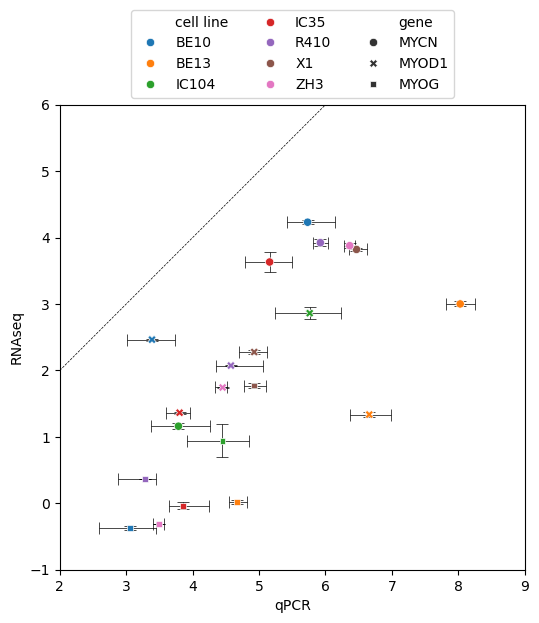

In [16]:
fig, ax = plt.subplots(figsize=(6, 8))

d = df_plot
sns.scatterplot(data=df_plot, x='qPCR', y='RNAseq', hue='cell line', style='gene', ax=ax)
ax.set_aspect(1)
ax.errorbar(
    x=d['qPCR'],
    y=d['RNAseq'],
    xerr=(d['qPCR'] - d['qPCR_min'], d['qPCR_max'] - d['qPCR']), 
    yerr=(d['RNAseq'] - d['RNA_min'], d['RNA_max'] - d['RNAseq']), 
    fmt='none', zorder=0,
    capsize=4,
    capthick=0.5,
    elinewidth=0.5,
    ecolor='k'
)
m = d[['qPCR', 'RNAseq']].min()
M = d[['qPCR', 'RNAseq']].max()
ax.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, 1))

m = 2
M = 6
ax.plot([m,M], [m,M], 'k--', lw=0.5)
ax.set_xlim(2, 9)
ax.set_ylim(-1, 6)
fig.savefig('../plots/qPCR_x_RNAseq.png', dpi=300)